In [2]:
import pandas as pd
from pykrige.ok import OrdinaryKriging
import numpy as np
import matplotlib.pyplot as plt
import json

def generate_kriging_json(filename, num_points, output_file):
    # Load data
    data = pd.read_csv(filename)

    # Drop any rows with missing data
    data.dropna(subset=['Value', 'lat', 'lng'], inplace=True)

    # Extract coordinates and values
    latitudes = data['lat'].values
    longitudes = data['lng'].values
    values = data['Value'].values

    # Define grid based on the specified number of points
    grid_lon = np.linspace(data['lng'].min(), data['lng'].max(), num_points)
    grid_lat = np.linspace(data['lat'].min(), data['lat'].max(), num_points)
    grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

    # Initialize and execute Ordinary Kriging
    ok_model = OrdinaryKriging(
        longitudes, latitudes, values,
        variogram_model='exponential',  # Example: Using an exponential model
        variogram_parameters={'sill': 94.41677613785475, 'range': 0.1, 'nugget': 13.881621490664376},
        verbose=True,
        enable_plotting=False
    )
    z, ss = ok_model.execute('grid', grid_lon[0], grid_lat[:,0])

    # Create JSON output and save to file
    output = []
    for i in range(num_points):
        for j in range(num_points):
            output.append({
                "lat": grid_lat[i, j],
                "lon": grid_lon[i, j],
                "value": z[i, j]
            })
    
    with open(output_file, 'w') as f:
        json.dump(output, f, indent=4)
    
    print(f"Data saved to {output_file}")

# Example usage
generate_kriging_json('processed.csv', 100, 'interp_data.json')  # Specify the output filename here

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 80.53515464719038
Full Sill: 94.41677613785475
Range: 0.1
Nugget: 13.881621490664376 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Data saved to interp_data.json


Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 80.53515464719038
Full Sill: 94.41677613785475
Range: 0.1
Nugget: 13.881621490664376 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



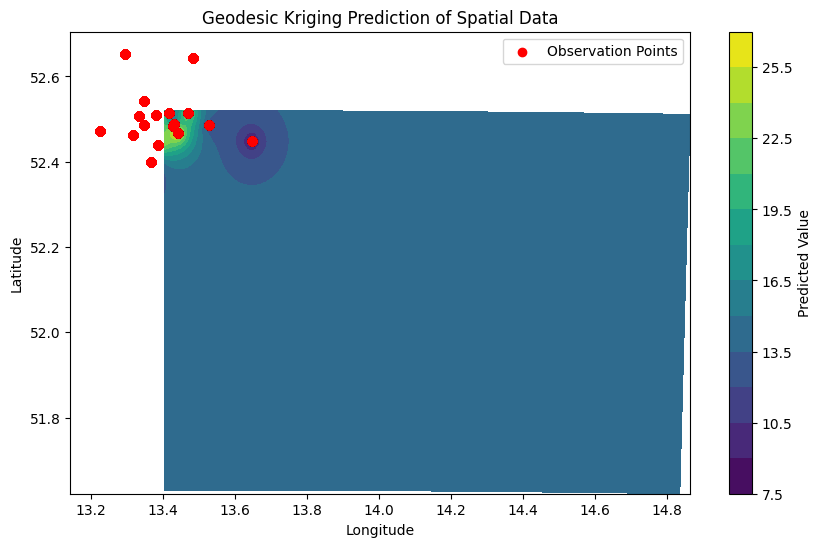

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from geopy.distance import geodesic

# Load your data
data = pd.read_csv('processed.csv')

# Drop any rows with missing data
data.dropna(subset=['Value', 'lat', 'lng'], inplace=True)

# Extract coordinates and values
latitudes = data['lat'].values
longitudes = data['lng'].values
values = data['Value'].values

# Define a grid for plotting
grid_lon = np.linspace(data['lng'].min(), data['lng'].max(), 100)
grid_lat = np.linspace(data['lat'].min(), data['lat'].max(), 100)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

# Initialize Ordinary Kriging with specified variogram parameters
ok_model = OrdinaryKriging(
    longitudes, latitudes, values,
    variogram_model='exponential',  # Example: Using an exponential model
    variogram_parameters={'sill': 94.41677613785475, 'range': 0.1, 'nugget': 13.881621490664376},
    verbose=True,
    enable_plotting=False
)



def create_geodesic_grid(start_lat, start_lng, grid_size, distance_km):
    # Grid will be grid_size x grid_size
    grid_lats = np.zeros((grid_size, grid_size))
    grid_lngs = np.zeros((grid_size, grid_size))
    
    # Initial point (top-left corner of the grid)
    origin = (start_lat, start_lng)
    
    # Create the grid
    for i in range(grid_size):
        # Move south by distance_km * i from the origin
        point_south = geodesic(kilometers=distance_km * i).destination(origin, bearing=180)
        for j in range(grid_size):
            # Move east by distance_km * j from the point_south
            grid_point = geodesic(kilometers=distance_km * j).destination(point_south, bearing=90)
            grid_lats[i, j] = grid_point.latitude
            grid_lngs[i, j] = grid_point.longitude

    return grid_lngs, grid_lats


def adjust_grid_to_be_quadratic(data, num_points):
    # Calculate the range for latitude and longitude
    latmax = 52.77
    latmin = 52.27
    lngmax = 13.68
    lngmin = 13.18
    lat_range = latmax - latmin
    lng_range = lngmax - lngmin
    print(lat_range)
    print(lng_range)

    # Find the aspect ratio
    aspect_ratio = lng_range / lat_range

    # Adjust number of points based on the aspect ratio to maintain a square grid
    if aspect_ratio > 1:
        num_lng = num_points
        num_lat = int(num_points / aspect_ratio)
    else:
        num_lat = num_points
        num_lng = int(num_points * aspect_ratio)

    # Generate grid
    grid_lon = np.linspace(lngmax, lngmin, num_lng)
    grid_lat = np.linspace(latmax, latmin, num_lat)
    
    print(f"Grid dimensions - Longitude: {num_lng}, Latitude: {num_lat}")
    
    return np.meshgrid(grid_lon, grid_lat)

# Use this function call within your script as before

start_lat = 52.2  # Example starting latitude
start_lng = 13.2  # Example starting longitude
grid_size = 100  # 10x10 grid
distance_km = 1  # 10 km between points

# Example usage with 100 as a base number of points
grid_lon, grid_lat = create_geodesic_grid(start_lat, start_lng, grid_size, distance_km)


# Perform the kriging on the defined grid
z, ss = ok_model.execute('grid', grid_lon[0], grid_lat[:,0])

def data_to_json(grid_lon, grid_lat, z, output_filename):
    results = []
    num_lat, num_lon = grid_lon.shape
    for i in range(num_lat):
        for j in range(num_lon):
            results.append({
                "lat": grid_lat[i, j],
                "lon": grid_lon[i, j],
                "value": z[i, j]
            })
    with open(output_filename, 'w') as f:
        json.dump(results, f, indent=4)

# Call the function to output JSON
data_to_json(grid_lon, grid_lat, z, 'interp_data.json')

plt.figure(figsize=(10, 6))
contour = plt.contourf(grid_lon, grid_lat, z, cmap='viridis', levels=15)
plt.scatter(longitudes, latitudes, color='red', marker='o', label='Observation Points')
plt.colorbar(contour, label='Predicted Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geodesic Kriging Prediction of Spatial Data')
plt.legend()
plt.show()
